# RGNN

## Introduction

## Setup
Here we load required libraries, define paths to data, and define some helper functions. **Feel free to skip this section.**

In [5]:
import numpy as np
import math
import json
import networkx as nx
import itertools

from IPython.display import HTML
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import dgl
from dgl.nn.pytorch import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import metrics
from sklearn import manifold

Using backend: pytorch


In [6]:
fp_data = "./datasets/"
fp_data_stargazer = f"{fp_data}github_stargazers/"
fp_data_webmluser = f"{fp_data}git_web_ml/"

In [122]:
# Helper function to visualize stargazer dataset graphs
def plot_stargazer_graph(G, label=None, print_info=False, labels=True):
    # Print info with graph if we want
    if print_info:  
        print(f"{G.number_of_nodes()} vertices")
        print(f"{G.number_of_edges()} edges")
        
    # Grey if no label, pink if 0, green if 1
    col = [[0.7, 0.7, 0.7]]
    if label is not None:
        if label == 0:
            col = [[0.6, 0, 0.6]]
        elif label == 1:
            col = [[0, 0.5, 0]]
    
    # Visualise as undirected
    nx_G = G.to_networkx().to_undirected()
    
    # Use the reconmmended Kamada-Kawaii layout for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=labels, node_color=col)

In [8]:
# Helper function to visualize the webmluser graph
def plot_webmluser_graph(G):    
    # Visualise as undirected
    nx_G = G.to_networkx().to_undirected()
    
    # Use the reconmmended Kamada-Kawaii layout for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, node_color=[[0.7, 0.7, 0.7]])

In [9]:
# Helper for getting batches from a dataset
def get_batches(xs, ys, batch_size=16):
    # How many batches is there of given size for this dataset
    num = len(xs)
    num_batches = math.ceil(num / batch_size)
    
    # Go through and get all batches
    batches_x = []
    batches_y = []
    
    # Get all batches in memory
    for i in range(num_batches - 1):
        sidx = batch_size * i
        fidx = batch_size * (i + 1)
        fidx = min(fidx, num)
        batches_x.append(xs[sidx:fidx])
        batches_y.append(ys[sidx:fidx])
        
    return batches_x, batches_y

## Datasets

### GitHub Stargazers Dataset
12,725 graphs of undirected developer social networks. Again, vertices are users who starred popular machine learning and web development repositories (with at least 10 stars), and edges are mutual follower relationships. The task is to classify each graph as a machine learning, or web development social network.

In [10]:
# Load the ground truth labels. Every element here here is a 
# [graph index, label] pair
stargazer_labels = np.loadtxt(f"{fp_data_stargazer}git_target.csv", \
                                  delimiter=",", skiprows=1)
    
# Adopting the accepted ML notation of input data (x) and labels (y)
stargazer_y = stargazer_labels[:,1].astype(int)

In [11]:
# Then we'll load the edges (defined against vertex ids) - note that there
# are no node or edge features, so predictions are made purely based on 
# undirected graph properties
with open(f"{fp_data_stargazer}git_edges.json") as f:
    stargazer_edges = json.load(f)

In [12]:
# Every item in this dictionary are the edges for a single graph, where each 
# edge is defined as a [vertex index, vertex index] pair. Here we show the 
# first 10 edges from graph 19
stargazer_edges['19'][:10]

[[0, 15],
 [1, 18],
 [1, 3],
 [1, 22],
 [1, 7],
 [1, 9],
 [1, 31],
 [2, 16],
 [3, 16],
 [3, 22]]

In [13]:
# This function takes the data loaded in the stargazer dataset form and turns 
# it into a DGL graph
def make_stargazer_graph(index):
    # Define every edge by its source and destination vertex ids
    edges = np.array(stargazer_edges[f"{index}"])
    src = edges[:,0]
    dst = edges[:,1]
    
    # Edges are directional in DGL; Make them undirectional by making them 
    # go both ways
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [14]:
# We can use this data to build each of the 12725 graphs as a single DGL
# graph object, thus forming our graph dataset
stargazer_x = []
for i in range(12725):
    G = make_stargazer_graph(i)
    stargazer_x.append(G)

38 vertices
110 edges


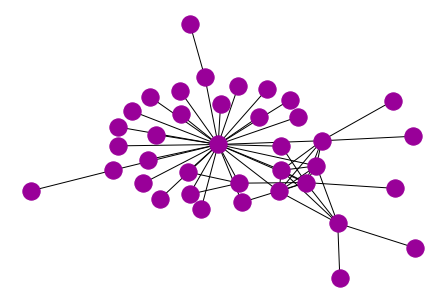

In [119]:
# Lets look at one of our graphs (pink for class 0, green for class 1)
plot_stargazer_graph(stargazer_x[19], label=stargazer_y[24], print_info=True, labels=False)

30 vertices
66 edges


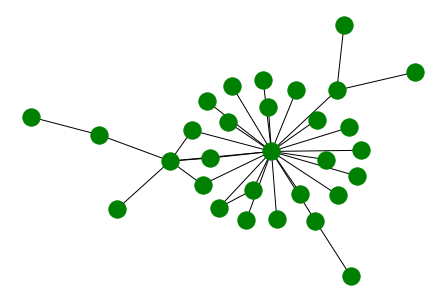

In [123]:
# Lets look at another - noting that the structure alone will be the inputs 
# to the GNN (no vertex or edge features), and that this will be sufficient
# to determine if the social network group is a ML developer group or 
# a Web developer group
plot_stargazer_graph(stargazer_x[24], label=stargazer_y[2], print_info=True, labels=False)

### GitHub Web or Machine Learning Dataset
One single graph representing the GitHub social network: vertices are users (who have starred at least 10 repositories) and edges represent if they mutually follow eachother. Each node has input features derived from profile data (location, repositories starred, employer and e-mail address), and belongs to one of two classes (derived from the user's job title): a web developer or machine learning developer. 

Note that using a single graph represents a departure from traditional supervised machine learning, where we typically use hundreds or thousands of training instances. In this application, it is perhaps easier to consider the **vertices** of the graph as training instances. Indeed, we will reserve some vertices for training and some for testing.

In [17]:
# Lets start by loading the vertices with their ground truth labels 
# and names attached. Every element is a [vertex index, name, label] triplet
webmluser_labels = np.loadtxt(f"{fp_data_webmluser}musae_git_target.csv", \
                                  delimiter=",", skiprows=1, usecols=[0,2])
webmluser_y = webmluser_labels[:,1].astype(int)

In [18]:
# Now load the associated vertex features
with open(f"{fp_data_webmluser}musae_git_features.json") as f:
    webmluser_features = json.load(f)

In [19]:
# There are 37700 vertices here, with each index keying into the features
# dictionary we just loaded. Here is an example of one vertex's features
print(webmluser_features['9001'])

[2657, 509, 3214, 3541, 3129, 1852, 3077, 3763, 536, 137, 2788, 1532, 3771, 234, 1991, 3813, 1651, 3887]


In [20]:
# Then we'll load the edges (defined against vertex id pairs)
webmluser_edges = np.loadtxt(f"{fp_data_webmluser}musae_git_edges.csv", \
                                  delimiter=",", skiprows=1)

In [21]:
# We only need to make on graph here, and that is our 'dataset'
def make_webmluser_graph():
    # Define every edge by its source and destination vertex ids
    src = webmluser_edges[:,0]
    dst = webmluser_edges[:,1]
    
    # Edges are directional in DGL; Make them undirectional by making them 
    # go both ways
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    
    # Construct a DGLGraph
    G = dgl.DGLGraph((u, v))
    
    # TODO vertex features
    
    return G

In [22]:
# Build the graph from the data - note that this is a big graph
webmluser_x = make_webmluser_graph()
print(f"{webmluser_x.number_of_nodes()} nodes")
print(f"{webmluser_x.number_of_edges()} edges")

37700 nodes
578006 edges


## Architectures
True RGNNs are seldom used in contemporary GNN work. RGNNs require a transition function to be repeatedly applied until convergence of the hidden states - an expensive computation. Instead of use true RGNNs here, we'll use GCNs with varying numbers of layers, thus mimicking the repeated application of a transition function.

In [23]:
# We want to experiment with the amount of computation required in the 
# forward pass, so we'll build various GNNs here, each with different 
# numbers of transition function layers
class StargazerGNN(nn.Module):
    def __init__(self, num_hidden_features):
        super().__init__()
        
        # We'll apply some number of spatial convolutions / message passing 
        # RGNNs
        self.convs = nn.ModuleList()
        for i in range(len(num_hidden_features) - 1):
            self.convs.append(GraphConv(num_hidden_features[i], 
                                        num_hidden_features[i+1]))
            
        # Classify out to one of two classes
        self.classify = nn.Linear(num_hidden_features[-1], 2)

    def forward(self, g):
        # Start with just the degree as a feature
        h = g.in_degrees().view(-1, 1).float()
        for i in range(len(self.convs)):
            h = self.convs[i](g, h)
            h = torch.relu(h)
            
        # Calculate graph representation by averaging all the node 
        # representations, thus making a graph representation
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        output = self.classify(hg)
        return output

    def hidden(self, g):
        # Start with just the degree as a feature
        h = g.in_degrees().view(-1, 1).float()
        for i in range(len(self.convs)):
            h = self.convs[i](g, h)
            h = torch.relu(h)
        
        return h

## Experiments

### Training and Testing

In [97]:
# The following operations will train the GNN
def train_stargazer_gnn(gnn, num_epochs):
    loss_func = nn.MSELoss()
    opt = torch.optim.Adam(itertools.chain(gnn.parameters()), 
                           lr=0.001)

    # Get the batches to work with
    num_train = 8096
    batches_x, batches_y = get_batches(stargazer_x[:num_train], \
                                       stargazer_y[:num_train], \
                                       batch_size=64)

    # Run every batch in every epoch
    epoch_losses = []
    for epoch_index in range(num_epochs):
        epoch_loss = 0
        for batch_index in range(len(batches_x)):
            # Get the batch of interest
            batch_x = batches_x[batch_index]
            batch_y = batches_y[batch_index]

            # Calculate an output for each graph
            x = dgl.batch(batch_x)
            y_hat = gnn(x)

            # And compare to the true value
            y = F.one_hot(torch.tensor(batch_y), num_classes=2).float()

            #print(y_hat)
            #print(y)

            # Calculate loss 
            loss = loss_func(y_hat, y)

            # Calculate loss and perform gradient descent step accordingly
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()
        epoch_loss /= len(batches_x)
        print(f"Epoch {epoch_index}: loss {epoch_loss}")
        epoch_losses.append(epoch_loss)
        
    # Return the trained architecture and loss
    return epoch_losses
    

In [98]:
# The following operation will test the GNN, returning hidden representations and 
# predictions
def test_stargazer_gnn(gnn):
    num_train = 8096
    num_test = 2048

    batches_x, batches_y = get_batches(stargazer_x[num_train:num_train+num_test],\
                                       stargazer_y[num_train:num_train+num_test],\
                                       batch_size=1)

    num_correct = 0
    y_true = []
    y_pred = []
    hidden = []
    for batch_index in range(len(batches_x)):
        # Get the batch of interest
        batch_x = batches_x[batch_index]
        batch_y = batches_y[batch_index]

        # Calculate an output for each graph
        x = dgl.batch(batch_x)
        y_hat = gnn(x)
        y_hat = torch.argmax(y_hat, dim=1).detach().numpy()

        # Also get some hidden representations for plotting
        h = torch.mean(gnn.hidden(x), dim=0).detach().numpy()
        hidden.append(h)

        # Take note of everything
        y_pred.extend(y_hat)
        y_true.extend(batch_y)
    hidden = np.array(hidden)
    
    return hidden, y_true, y_pred

As en example, lets now use these functions to train and test a Stargazer GNN.

In [87]:
stargazer_gnn_example = StargazerGNN([1, 4, 4, 4])
epoch_losses = train_stargazer_gnn(stargazer_gnn_example, 8)

Epoch 0: loss 3.1106092825768488
Epoch 1: loss 0.6139002151432491
Epoch 2: loss 0.36539904347487856
Epoch 3: loss 0.34547367597383166
Epoch 4: loss 0.32829727705508943
Epoch 5: loss 0.31325380433173405
Epoch 6: loss 0.30035426195651765
Epoch 7: loss 0.28945648410017527


In [88]:
hidden, y_true, y_pred = test_stargazer_gnn(stargazer_gnn_example)

In [89]:
print(metrics.classification_report(y_true, y_pred, \
                                    target_names=['web', 'ml']))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
print(f"AUC\t{metrics.auc(fpr, tpr)}")

              precision    recall  f1-score   support

         web       0.50      0.01      0.01       991
          ml       0.52      0.99      0.68      1056

    accuracy                           0.52      2047
   macro avg       0.51      0.50      0.35      2047
weighted avg       0.51      0.52      0.36      2047

AUC	0.5001863361159526


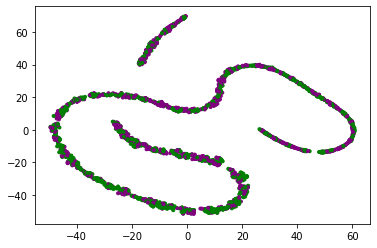

In [90]:
# Plot a TSNE fit on the features
tsne = manifold.TSNE(n_components=2)
tsne_embedded = tsne.fit_transform(hidden)
tsne_embedded.shape
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], \
            marker='.', c=y_true, 
            cmap=matplotlib.colors.ListedColormap(['purple', 'green']))

### Results and Discussion

In [108]:
# Now lets wrap all this up into one function so we can test 
# multiple architectures
def train_test_architecture(num_hidden_features, num_epochs):
    # Make architecture and train
    gnn_run = StargazerGNN(num_hidden_features)
    epoch_losses = train_stargazer_gnn(gnn_run, num_epochs)
    
    if num_epochs > 0:
        plt.plot(range(num_epochs), epoch_losses)
        plt.ylim((0, 1.0))
        plt.title("Loss during training")
        plt.show()
    
    # Test and return hidden representations plus predictions
    hidden, y_true, y_pred = test_stargazer_gnn(gnn_run)
    
    # Print performance metrics
    print(metrics.classification_report(y_true, y_pred, \
                                        target_names=['web', 'ml']))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    print(f"AUC\t{metrics.auc(fpr, tpr)}")
    
    # Plot TSNE visualization
    tsne = manifold.TSNE(n_components=2)
    tsne_embedded = tsne.fit_transform(hidden)
    tsne_embedded.shape
    plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], \
                marker='.', c=y_true, 
                cmap=matplotlib.colors.ListedColormap(['purple', 'green']))

/home/prang/miniconda3/envs/gnn-tutorial/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         web       0.48      1.00      0.65       991
          ml       0.00      0.00      0.00      1056

    accuracy                           0.48      2047
   macro avg       0.24      0.50      0.33      2047
weighted avg       0.23      0.48      0.32      2047

AUC	0.5


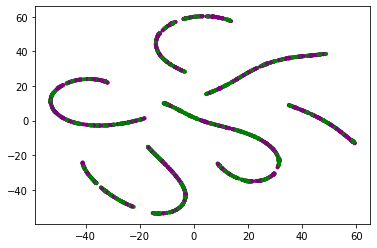

In [109]:
train_test_architecture([1, 8], 0)

Epoch 0: loss 0.4539971739526779
Epoch 1: loss 0.31724357534022557
Epoch 2: loss 0.2866110092117673
Epoch 3: loss 0.2661418146084225
Epoch 4: loss 0.25462232400027535
Epoch 5: loss 0.24939969489498745
Epoch 6: loss 0.24753581992690527
Epoch 7: loss 0.24700776050015102
Epoch 8: loss 0.24688531399246247
Epoch 9: loss 0.24686147792944832
Epoch 10: loss 0.24685808010990656
Epoch 11: loss 0.2468586672866155
Epoch 12: loss 0.24686015125304933
Epoch 13: loss 0.24686197380697916
Epoch 14: loss 0.2468640301672239
Epoch 15: loss 0.24686623341034328


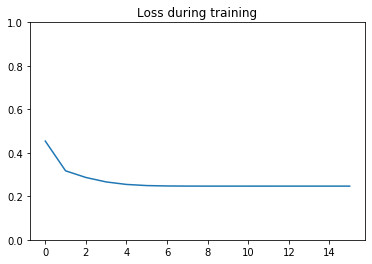

              precision    recall  f1-score   support

         web       0.51      0.23      0.32       991
          ml       0.52      0.79      0.63      1056

    accuracy                           0.52      2047
   macro avg       0.52      0.51      0.47      2047
weighted avg       0.52      0.52      0.48      2047

AUC	0.5108997072134055


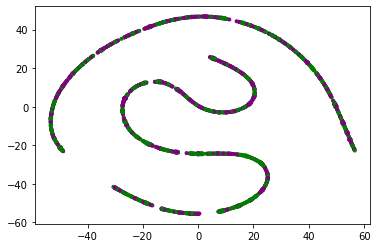

In [110]:
train_test_architecture([1, 8], 16)

Epoch 0: loss 0.2705864738377314
Epoch 1: loss 0.2565393012667459
Epoch 2: loss 0.2509244598803066
Epoch 3: loss 0.24889445328523244
Epoch 4: loss 0.24813227568353927
Epoch 5: loss 0.247825693398241
Epoch 6: loss 0.24768904939530387
Epoch 7: loss 0.247617436188554
Epoch 8: loss 0.24757214978573813
Epoch 9: loss 0.24753736432582613
Epoch 10: loss 0.2475072049668857
Epoch 11: loss 0.24747844241441241
Epoch 12: loss 0.24744994654541924
Epoch 13: loss 0.2474204787895793
Epoch 14: loss 0.24739003855557667
Epoch 15: loss 0.24735749808568802


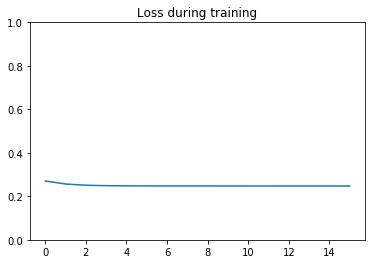

              precision    recall  f1-score   support

         web       0.57      0.31      0.40       991
          ml       0.55      0.78      0.64      1056

    accuracy                           0.55      2047
   macro avg       0.56      0.54      0.52      2047
weighted avg       0.56      0.55      0.52      2047

AUC	0.544005423814329


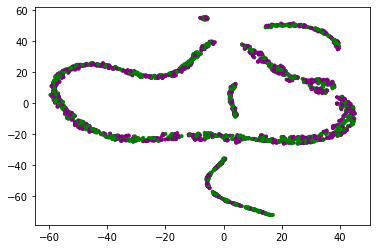

In [117]:
train_test_architecture([1, 8, 8], 16)

Epoch 0: loss 0.557766336297232
Epoch 1: loss 0.27512980713730767
Epoch 2: loss 0.258871577088795
Epoch 3: loss 0.25221725837105796
Epoch 4: loss 0.2500662426390345
Epoch 5: loss 0.24932356486244808
Epoch 6: loss 0.24892853980972654
Epoch 7: loss 0.24860296209180166
Epoch 8: loss 0.24826868245052913
Epoch 9: loss 0.24789332586621482
Epoch 10: loss 0.24746269389750467
Epoch 11: loss 0.24695828533361827
Epoch 12: loss 0.24637362786701747
Epoch 13: loss 0.24569973586097596
Epoch 14: loss 0.24492572425376802
Epoch 15: loss 0.24407119303941727


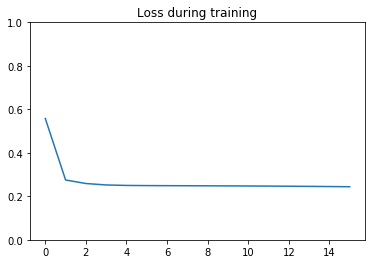

              precision    recall  f1-score   support

         web       0.62      0.26      0.36       991
          ml       0.55      0.85      0.67      1056

    accuracy                           0.56      2047
   macro avg       0.59      0.55      0.52      2047
weighted avg       0.58      0.56      0.52      2047

AUC	0.5547321728893373


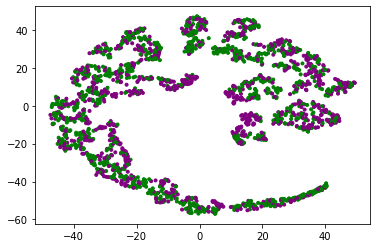

In [112]:
train_test_architecture([1, 8, 8, 8, 8], 16)

Epoch 0: loss 0.2624855591427712
Epoch 1: loss 0.24383376668843013
Epoch 2: loss 0.2375873372195259
Epoch 3: loss 0.22965361982110946
Epoch 4: loss 0.22540190472962365
Epoch 5: loss 0.2234482223552371
Epoch 6: loss 0.2223969150393728
Epoch 7: loss 0.22170542109580266
Epoch 8: loss 0.22120739732469832
Epoch 9: loss 0.22082876579629052
Epoch 10: loss 0.2205165121999998
Epoch 11: loss 0.22025062593202743
Epoch 12: loss 0.2200024915593011
Epoch 13: loss 0.21981154027439298
Epoch 14: loss 0.21960956969904522
Epoch 15: loss 0.2194247662074982


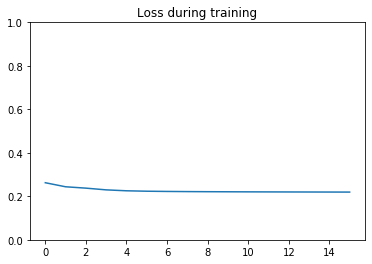

              precision    recall  f1-score   support

         web       0.68      0.49      0.57       991
          ml       0.62      0.78      0.69      1056

    accuracy                           0.64      2047
   macro avg       0.65      0.64      0.63      2047
weighted avg       0.65      0.64      0.63      2047

AUC	0.637756857169067


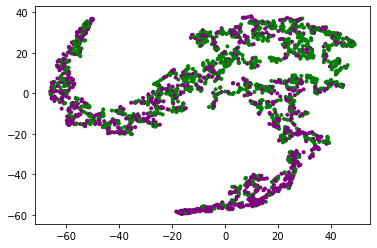

In [113]:
train_test_architecture([1, 8, 8, 8, 8, 8, 8, 8, 8, 8], 16)